# Bible Text Batch Processing with KG Engine

This notebook demonstrates batch processing of the Bible text file using KG Engine v2 with Ollama.

## Setup and Configuration

In [1]:
import os
import sys
from pathlib import Path
import time
import logging

logging.getLogger().setLevel(logging.INFO)
logging.getLogger('openai').setLevel(logging.WARNING)
# Add src to Python path
src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Load environment variables
from dotenv import load_dotenv
load_dotenv('../.env.notebook')

# Disable tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print(f"✅ Environment loaded")
print(f"   Ollama Model: {os.getenv('OLLAMA_MODEL')}")
print(f"   Ollama URL: {os.getenv('OLLAMA_BASE_URL')}")

✅ Environment loaded
   Ollama Model: phi3:3.8b
   Ollama URL: http://localhost:11434/v1


## Import KG Engine Components

In [2]:
from kg_engine import (
    KnowledgeGraphEngineV2,
    InputItem,
    Neo4jConfig,
    LLMClientFactory
)

print("✅ KG Engine components imported")

✅ KG Engine components imported


## Initialize Engine with Ollama

In [3]:
# Create Neo4j configuration
neo4j_config = Neo4jConfig()

# Verify Neo4j connectivity
if neo4j_config.verify_connectivity():
    print("✅ Neo4j connected")
else:
    print("❌ Neo4j connection failed")
    raise ConnectionError("Cannot connect to Neo4j")

# Create LLM configuration from environment
llm_config = LLMClientFactory.create_from_env()
print(f"✅ LLM Config: {llm_config.provider} - {llm_config.get_model_name()}")

# Initialize the engine
engine = KnowledgeGraphEngineV2(
    llm_config=llm_config,
    neo4j_config=neo4j_config
)

print("\n🚀 KG Engine initialized and ready!")

INFO:root:Neo4j connectivity verified bolt://localhost:7687, neo4j, neo4j
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


✅ Neo4j connected
✅ LLM Config: litellm - gpt-4o


INFO:sentence_transformers.cross_encoder.CrossEncoder:Use pytorch device: mps
INFO:kg_engine.utils.neo4j_index_manager:Vector index triplet_embedding_index already exists, skipping creation
INFO:kg_engine.models.classifier_map:Loaded classifier map with 8 categories


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🤖 LLM Interface initialized: gpt-4o via litellm
🚀 Knowledge Graph Engine v2
   - LLM interface: gpt-4o via litellm

🚀 KG Engine initialized and ready!


## Load and Prepare Bible Text

In [7]:
# Path to Bible text file
bible_path = Path('../examples/sample_documents/bible.txt')

# Read the Bible text
with open(bible_path, 'r', encoding='utf-8') as f:
    bible_text = f.read()

# Split into verses (assuming each verse is on a new line)
verses = [line.strip() for line in bible_text.split('\n') if line.strip() and ':' in line]

print(f"📖 Loaded Bible text")
print(f"   Total verses: {len(verses)}")
print(f"   First verse: {verses[0] if verses else 'None'}")
print(f"   Last verse: {verses[-1] if verses else 'None'}")

📖 Loaded Bible text
   Total verses: 37026
   First verse: 1:1 In the beginning God created the heaven and the earth.
   Last verse: http://www.gutenberg.org


## Define Batch Processing Parameters

In [8]:
# Batch processing parameters
BATCH_SIZE = 5  # Number of verses per batch
NUM_BATCHES = 50  # Number of batches to process (set None for all)
DELAY_BETWEEN_BATCHES = 1  # Seconds to wait between batches

# Calculate total batches
total_possible_batches = len(verses) // BATCH_SIZE
batches_to_process = min(NUM_BATCHES or total_possible_batches, total_possible_batches)

print(f"⚙️ Batch Processing Configuration:")
print(f"   Batch size: {BATCH_SIZE} verses")
print(f"   Batches to process: {batches_to_process}")
print(f"   Total verses to process: {batches_to_process * BATCH_SIZE}")
print(f"   Delay between batches: {DELAY_BETWEEN_BATCHES}s")

⚙️ Batch Processing Configuration:
   Batch size: 5 verses
   Batches to process: 50
   Total verses to process: 250
   Delay between batches: 1s


## Process Batches

In [9]:
# Initialize tracking variables
total_stats = {
    "processed_items": 0,
    "new_edges": 0,
    "updated_edges": 0,
    "obsoleted_edges": 0,
    "duplicates_ignored": 0,
    "errors": [],
    "processing_time_ms": 0
}

batch_results = []

print("🔄 Starting batch processing...\n")

# Process batches
for batch_num in range(batches_to_process):
    start_idx = batch_num * BATCH_SIZE
    end_idx = start_idx + BATCH_SIZE
    
    # Get verses for this batch
    batch_verses = verses[start_idx:end_idx]
    
    # Create InputItems
    input_items = [
        InputItem(
            description=verse,
            metadata={
                "source": "bible",
                "batch_number": batch_num + 1,
                "verse_index": start_idx + i
            }
        )
        for i, verse in enumerate(batch_verses)
    ]
    
    print(f"📦 Batch {batch_num + 1}/{batches_to_process}")
    print(f"   Verses {start_idx + 1}-{end_idx}")
    print(f"   First verse: {batch_verses[0][:50]}...")
    
    # Process the batch
    try:
        batch_start_time = time.time()
        results = engine.process_input(input_items)
        batch_time = (time.time() - batch_start_time) * 1000
        
        # Store batch results
        batch_results.append({
            "batch_number": batch_num + 1,
            "results": results,
            "processing_time_ms": batch_time
        })
        
        # Update totals
        total_stats["processed_items"] += results.get("processed_items", 0)
        total_stats["new_edges"] += results.get("new_edges", 0)
        total_stats["updated_edges"] += results.get("updated_edges", 0)
        total_stats["obsoleted_edges"] += results.get("obsoleted_edges", 0)
        total_stats["duplicates_ignored"] += results.get("duplicates_ignored", 0)
        total_stats["processing_time_ms"] += batch_time
        
        if results.get("errors"):
            total_stats["errors"].extend(results["errors"])
        
        print(f"   ✅ Processed in {batch_time:.1f}ms")
        print(f"   New edges: {results.get('new_edges', 0)}")
        print(f"   Errors: {len(results.get('errors', []))}")
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        total_stats["errors"].append(f"Batch {batch_num + 1}: {str(e)}")
    
    # Delay between batches (except for the last one)
    if batch_num < batches_to_process - 1:
        time.sleep(DELAY_BETWEEN_BATCHES)
    
    print()  # Empty line between batches

print("✅ Batch processing complete!")

🔄 Starting batch processing...

📦 Batch 1/50
   Verses 1-5
   First verse: 1:1 In the beginning God created the heaven and th...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CREATED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CREATED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> heaven


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> earth
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'APPEARS' -> 'appears' in category 'status' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: EXISTS -> APPEARS


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> light


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: light -APPEARS-> light
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAW -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'APPEARS' -> 'appears' in category 'status' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: HAS_STATUS -> APPEARS


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: DIVIDED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> light


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: light -APPEARS-> good
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CALLED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CALLED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> Day


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> Night


   ✅ Processed in 14350.3ms
   New edges: 8
   Errors: 0

📦 Batch 2/50
   Verses 6-10
   First verse: 1:6 And God said, Let there be a firmament in the ...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> firmament
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'CREATED_THE' -> 'created the' in category 'creation' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: MADE -> CREATED_THE


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'MADE_AND_DIVIDED' -> 'made and divided' in category 'creation' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: DIVIDED -> MADE_AND_DIVIDED


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -CREATED_THE-> firmament


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -MADE_AND_DIVIDED-> waters
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CALLED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> Heaven
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> waters


   ✅ Processed in 10505.5ms
   New edges: 5
   Errors: 0

📦 Batch 3/50
   Verses 11-15
   First verse: unto one place, and let the dry land appear: and i...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CALLED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> Earth
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'APPEARS' -> 'appears' in category 'status' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAW -> APPEARS


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -APPEARS-> good
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> earth
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


   ✅ Processed in 9208.3ms
   New edges: 3
   Errors: 0

📦 Batch 4/50
   Verses 16-20
   First verse: 1:12 And the earth brought forth grass, and herb y...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> lights in the firmament of the heaven
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


   ✅ Processed in 5979.4ms
   New edges: 1
   Errors: 0

📦 Batch 5/50
   Verses 21-25
   First verse: the firmament of the heaven to give light upon the...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: MADE -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'APPEARS' -> 'appears' in category 'status' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: RULES -> APPEARS


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> two great lights


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: greater light -APPEARS-> day
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SET_IN -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: PURPOSE -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> firmament


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: them -SURVIVES_TOGETHER-> give light
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


   ✅ Processed in 9375.7ms
   New edges: 4
   Errors: 0

📦 Batch 6/50
   Verses 26-30
   First verse: to divide the light from the darkness: and God saw...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: DIVIDES -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: DIVIDES -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'APPEARS' -> 'appears' in category 'status' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SEES_AS_GOOD -> APPEARS


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> darkness


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -APPEARS-> it
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CREATED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CREATED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> whale


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> living creature
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


   ✅ Processed in 11247.0ms
   New edges: 4
   Errors: 0

📦 Batch 7/50
   Verses 31-35
   First verse: 1:22 And God blessed them, saying, Be fruitful, an...


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:kg_engine.utils.graph_standardizer:Standardized: BLESSED -> BLESSED


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -BLESSED-> them
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'CREATED_THE' -> 'created the' in category 'creation' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: MADE -> CREATED_THE


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'CREATED_THE' -> 'created the' in category 'creation' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: MADE -> CREATED_THE


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -CREATED_THE-> beast


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -CREATED_THE-> cattle


   ✅ Processed in 6820.6ms
   New edges: 3
   Errors: 0

📦 Batch 8/50
   Verses 36-40
   First verse: his kind: and God saw that it was good....


INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> Let us make man in our image, after our likeness
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_TOGETHER' -> 'survives together' in category 'activity' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: CREATED -> SURVIVES_TOGETHER


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SURVIVES_TOGETHER-> man
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"
INFO:kg_engine.utils.graph_standardizer:Standardized: BLESSED -> BLESSED


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SAID' -> 'said' in category 'communication' with embedding cache
INFO:kg_engine.utils.graph_standardizer:Standardized: SAID_UNTO -> SAID


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Added edge: God -SAID-> them
INFO:httpx:HTTP Request: POST https://litellm.chatcyber.ai/chat/completions "HTTP/1.1 200 OK"


   ✅ Processed in 9449.7ms
   New edges: 3
   Errors: 0


KeyboardInterrupt: 

## Processing Summary

In [20]:
print("📊 Final Processing Statistics:")
print(f"   Total batches processed: {len(batch_results)}")
print(f"   Total items processed: {total_stats['processed_items']}")
print(f"   Total new edges: {total_stats['new_edges']}")
print(f"   Total updated edges: {total_stats['updated_edges']}")
print(f"   Total obsoleted edges: {total_stats['obsoleted_edges']}")
print(f"   Total duplicates ignored: {total_stats['duplicates_ignored']}")
print(f"   Total errors: {len(total_stats['errors'])}")
print(f"   Total processing time: {total_stats['processing_time_ms']:.1f}ms")
print(f"   Average time per batch: {total_stats['processing_time_ms'] / len(batch_results):.1f}ms")

# Show sample errors if any
if total_stats['errors']:
    print("\n⚠️ Sample errors (first 5):")
    for i, error in enumerate(total_stats['errors'][:5]):
        print(f"   {i+1}. {error}")

📊 Final Processing Statistics:
   Total batches processed: 20
   Total items processed: 100
   Total new edges: 111
   Total updated edges: 0
   Total obsoleted edges: 0
   Total duplicates ignored: 16
   Total errors: 6
   Total processing time: 319631.7ms
   Average time per batch: 15981.6ms

⚠️ Sample errors (first 5):
   1. No existing relationship found to obsolete: The LORD God had not allowed any herb to grow in the field prior.
   2. No existing relationship found to obsolete: You may not eat from the tree of the knowledge.
   3. No existing relationship found to obsolete: Reader shall not eat of the forbidden item.
   4. No existing relationship found to obsolete: Should not eat from all trees in the garden.
   5. No existing relationship found to obsolete: The serpent said to the woman, 'You shall not surely die.'


## View Graph Statistics

In [21]:
# Get current graph statistics
stats = engine.get_stats()

print("📈 Current Graph Statistics:")
print(f"   Total entities: {stats.get('entities', 0)}")
print(f"   Active edges: {stats.get('graph_stats', {}).get('active_edges', 0)}")
print(f"   Total edges: {stats.get('graph_stats', {}).get('total_edges', 0)}")
print(f"   Relationship types: {stats.get('graph_stats', {}).get('relationship_types', 0)}")

# Show sample relationships
relationships = stats.get('relationships', [])
if relationships:
    print(f"\n📋 Sample relationship types (first 10):")
    for rel in relationships[:10]:
        print(f"   - {rel}")

📈 Current Graph Statistics:
   Total entities: 154
   Active edges: 140
   Total edges: 140
   Relationship types: 17

📋 Sample relationship types (first 10):
   - RELATES_TO
   - CREATED_THE
   - WAS_STATE
   - SAID_TO_CREATE
   - SURVIVES_TOGETHER
   - CALLED_LITERALLY
   - SAID
   - MADE_AND_DIVIDED
   - UNDER
   - IS_CALLED


## Test Queries

In [22]:
# Test some queries on the processed data
test_queries = [
    "Who created the heaven and earth?",
    "What did God create on the first day?",
    "What is the firmament?"
]

print("🔍 Testing queries on processed data:\n")

for query in test_queries:
    print(f"Q: {query}")
    try:
        response = engine.search(query)
        print(f"A: {response.answer}")
        print(f"   (Found {len(response.results)} results in {response.query_time_ms:.1f}ms)")
    except Exception as e:
        print(f"   Error: {e}")
    print()

🔍 Testing queries on processed data:

Q: Who created the heaven and earth?
Search type: SearchType.BOTH Who created the heaven and earth?
Parsing query DIRECT with LLM intuition...


INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


Parsed query: ParsedQuery(entities=['Heaven and Earth'], relationships=['CREATED'], search_type=<SearchType.DIRECT: 'direct'>, query_intent='search', temporal_context=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'CREATED_THE' -> 'created the' in category 'creation' with embedding cache
INFO:kg_engine.core.engine:Standardized 'CREATED' -> 'CREATED_THE' (category: creation)
INFO:kg_engine.storage.graph_db:Entity exploration returned 0 results for Heaven and Earth


Standardized relationships: ['CREATED_THE']
Searching with entities: ['Heaven and Earth'] and relationships: ['CREATED', 'CREATED_THE']
Parsing query SEMANTIC...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Vector similarity search returned 10 results
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


A: In the beginning, God created heaven and earth. This concept comes from religious texts such as Genesis in the Bible. It is important to note that interpretations may vary among different beliefs.
   (Found 10 results in 3200.0ms)

Q: What did God create on the first day?
Search type: SearchType.BOTH What did God create on the first day?
Parsing query DIRECT with LLM intuition...


INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


Parsed query: ParsedQuery(entities=['God', 'first day'], relationships=['CREATED', 'FIRST_DAY'], search_type=<SearchType.DIRECT: 'direct'>, query_intent='search', temporal_context=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'CREATED_THE' -> 'created the' in category 'creation' with embedding cache
INFO:kg_engine.core.engine:Standardized 'CREATED' -> 'CREATED_THE' (category: creation)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'IS_ON' -> 'is on' in category 'location' with embedding cache
INFO:kg_engine.core.engine:Standardized 'FIRST_DAY' -> 'IS_ON' (category: location)
INFO:kg_engine.storage.graph_db:Entity exploration returned 10 results for God
INFO:kg_engine.storage.graph_db:Entity exploration returned 0 results for first day
INFO:kg_engine.storage.graph_db:Found 0 paths from God to first day


Standardized relationships: ['CREATED_THE', 'IS_ON']
Searching with entities: ['God', 'first day'] and relationships: ['CREATED', 'FIRST_DAY', 'CREATED_THE', 'IS_ON']
Parsing query SEMANTIC...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Vector similarity search returned 10 results
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


A: On the first day of creation, God made light and separated it from darkness. He then created the sky as a dome above this new space where life could exist under his guidance. The rest was seen as good by Him. This includes land animals like cattle that were also part of His creations on Earth.
   (Found 10 results in 4454.0ms)

Q: What is the firmament?
Search type: SearchType.BOTH What is the firmament?
Parsing query DIRECT with LLM intuition...


INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


Parsed query: ParsedQuery(entities=['firmament'], relationships=['DEFINED_AS'], search_type=<SearchType.DIRECT: 'direct'>, query_intent='search', temporal_context=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.utils.graph_standardizer:✅ Successfully synced new edge 'SURVIVES_INTO' -> 'survives into' in category 'nature' with embedding cache
INFO:kg_engine.core.engine:Standardized 'DEFINED_AS' -> 'SURVIVES_INTO' (category: nature)
INFO:kg_engine.storage.graph_db:Entity exploration returned 0 results for firmament


Standardized relationships: ['SURVIVES_INTO']
Searching with entities: ['firmament'] and relationships: ['DEFINED_AS', 'SURVIVES_INTO']
Parsing query SEMANTIC...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:kg_engine.storage.graph_db:Vector similarity search returned 10 results
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


A: The firmament refers to a solid dome that was believed by ancient cultures like the Hebrews and Greeks to separate the waters above from the land below. In religious texts, such as in Genesis chapter one of the Bible, it is described as Heaven being created when God spoke, saying "Let there be a firmament." This term has been used historically to describe what we might now refer to more accurately as the sky or atmosphere where clouds and weather occur.
   (Found 10 results in 4561.6ms)



## Graph Visualization

In [18]:
# Analyze graph structure
def analyze_graph_structure(G):
    """Analyze and display graph structure statistics"""
    print("📈 Graph Structure Analysis:")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    
    if G.number_of_nodes() > 0:
        # Degree analysis
        degrees = [G.degree(node) for node in G.nodes()]
        avg_degree = sum(degrees) / len(degrees)
        max_degree = max(degrees)
        
        print(f"   Average degree: {avg_degree:.2f}")
        print(f"   Maximum degree: {max_degree}")
        
        # Find most connected nodes
        degree_dict = dict(G.degree())
        top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print("\\n🔗 Most Connected Entities:")
        for node, degree in top_nodes:
            print(f"   {node}: {degree} connections")
        
        # Relationship type distribution
        relationships = [G[u][v]['relationship'] for u, v in G.edges()]
        rel_counts = {}
        for rel in relationships:
            rel_counts[rel] = rel_counts.get(rel, 0) + 1
        
        top_rels = sorted(rel_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\\n📊 Most Common Relationships:")
        for rel, count in top_rels:
            print(f"   {rel}: {count} edges")

if 'G' in locals():
    analyze_graph_structure(G)

In [ ]:
# Install required packages for visualization
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install visualization packages
install_package("networkx")
install_package("matplotlib")
install_package("plotly")

print("✅ Visualization packages ready")

In [5]:
# %pip install networkx matplotlib plotly

📊 Fetching graph data (limit: 50)...
✅ Retrieved 50 relationships
\n🎨 Creating visualizations for 50 relationships...
   Graph has 58 nodes and 42 edges
\n📊 Creating static visualization...


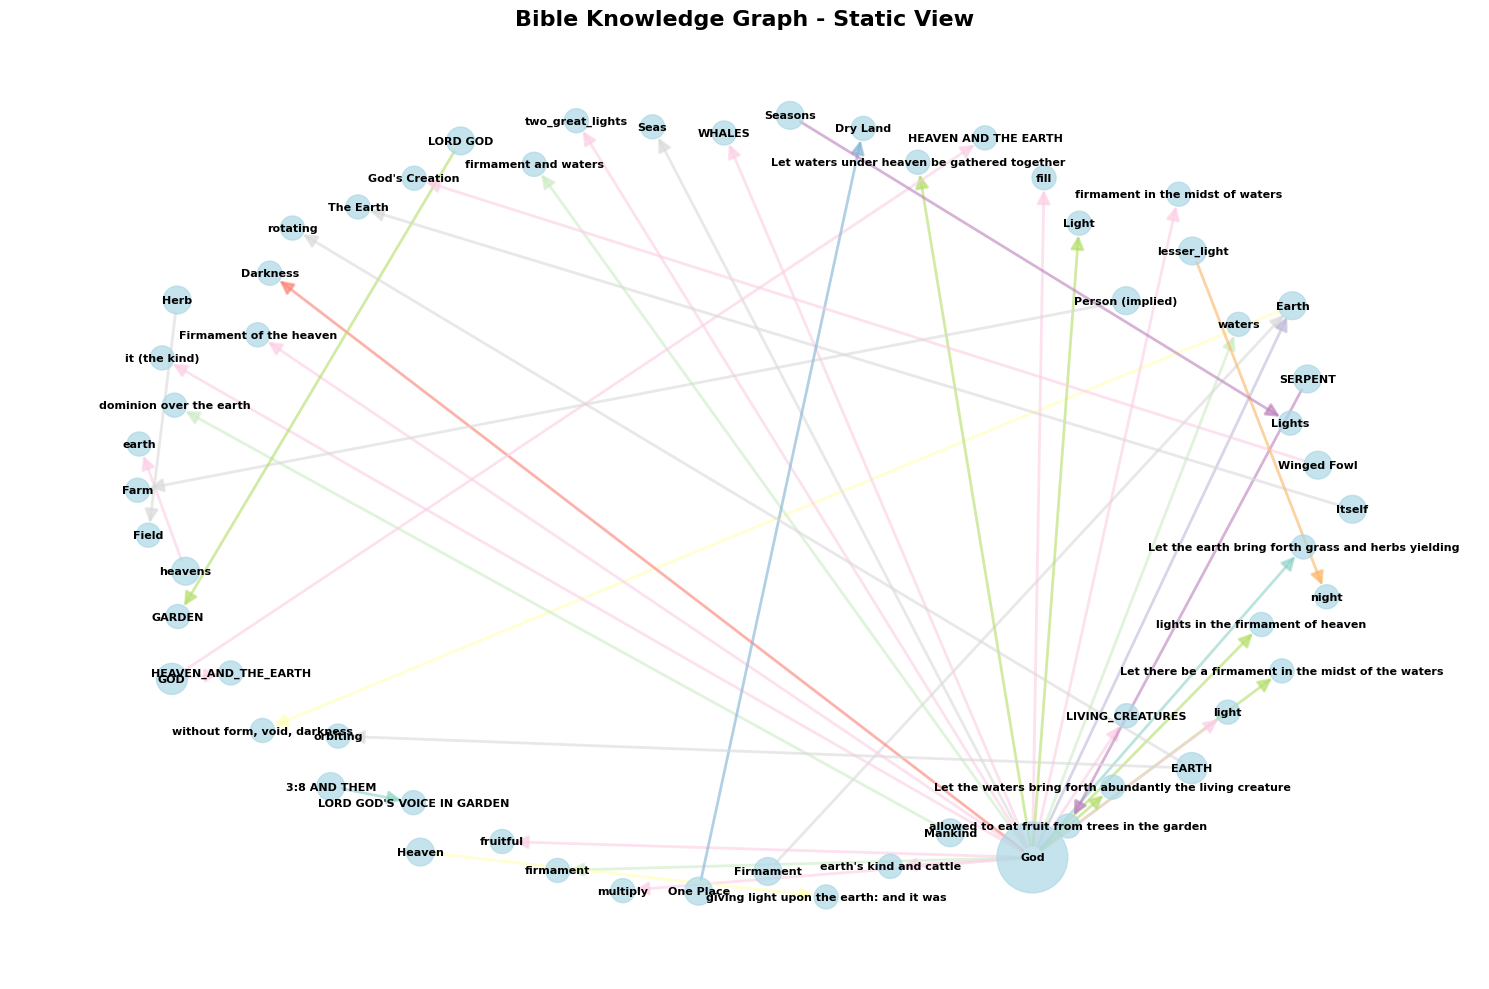

📋 Relationship Types in Graph:
   1. SAID_TO
   2. WAS_STATE
   3. IS_CALLED
   4. CALLED_LITERALLY
   5. BECOMES_DRY
   6. SURVIVES_TOGETHER
   7. SAID
   8. CREATED_THE
   9. UNDER
   10. SURVIVES_INTO
\n🔄 Creating interactive visualization...


In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from collections import defaultdict
import random

def get_graph_data_for_visualization(engine, limit=100):
    """Get graph data from Neo4j for visualization"""
    print(f"📊 Fetching graph data (limit: {limit})...")
    
    try:
        # Get all relationships with their entities
        with engine.graph_db.driver.session(database=engine.graph_db.config.database) as session:
            result = session.run(f"""
                MATCH (s:Entity)-[r]->(o:Entity)
                WHERE r.obsolete = false
                RETURN s.name as subject, type(r) as relationship, o.name as object, 
                       r.confidence as confidence, r.summary as summary
                ORDER BY r.confidence DESC
                LIMIT {limit}
            """)
            
            relationships = []
            for record in result:
                relationships.append({
                    'subject': record['subject'],
                    'relationship': record['relationship'], 
                    'object': record['object'],
                    'confidence': record['confidence'],
                    'summary': record['summary']
                })
            
        print(f"✅ Retrieved {len(relationships)} relationships")
        return relationships
        
    except Exception as e:
        print(f"❌ Error fetching graph data: {e}")
        return []

def create_networkx_graph(relationships):
    """Create NetworkX graph from relationships"""
    G = nx.DiGraph()
    
    # Add edges with attributes
    for rel in relationships:
        G.add_edge(
            rel['subject'], 
            rel['object'],
            relationship=rel['relationship'],
            confidence=rel['confidence'],
            summary=rel['summary']
        )
    
    return G

def visualize_graph_matplotlib(G, title="Knowledge Graph Visualization"):
    """Create static visualization using matplotlib"""
    plt.figure(figsize=(15, 10))
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Draw nodes
    node_sizes = [300 + len(G.edges(node)) * 100 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color='lightblue', alpha=0.7)
    
    # Draw edges with different colors for different relationships
    edge_colors = []
    relationships = [G[u][v]['relationship'] for u, v in G.edges()]
    unique_rels = list(set(relationships))
    color_map = {rel: plt.cm.Set3(i/len(unique_rels)) for i, rel in enumerate(unique_rels)}
    
    for u, v in G.edges():
        rel = G[u][v]['relationship']
        edge_colors.append(color_map[rel])
    
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                          arrows=True, arrowsize=20, alpha=0.6, width=2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    plt.title(title, size=16, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Show relationship type legend
    print("📋 Relationship Types in Graph:")
    for i, rel in enumerate(unique_rels[:10]):  # Show first 10
        print(f"   {i+1}. {rel}")

def visualize_graph_plotly(relationships, title="Interactive Knowledge Graph"):
    """Create interactive visualization using Plotly"""
    
    # Create NetworkX graph for layout
    G = create_networkx_graph(relationships)
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Extract node and edge information
    node_x = []
    node_y = []
    node_text = []
    node_info = []
    
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
        
        # Count connections
        connections = len(G.edges(node))
        node_info.append(f"{node}<br>Connections: {connections}")
    
    # Create edge traces
    edge_x = []
    edge_y = []
    edge_info = []
    
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        
        # Get edge information
        rel_data = G[edge[0]][edge[1]]
        edge_info.append(f"{edge[0]} → {edge[1]}<br>{rel_data['relationship']}<br>Confidence: {rel_data['confidence']:.2f}")
    
    # Create edge trace
    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                           line=dict(width=2, color='#888'),
                           hoverinfo='none',
                           mode='lines')
    
    # Create node trace
    node_trace = go.Scatter(x=node_x, y=node_y,
                           mode='markers+text',
                           hoverinfo='text',
                           text=node_text,
                           textposition='middle center',
                           hovertext=node_info,
                           marker=dict(showscale=True,
                                     colorscale='Viridis',
                                     reversescale=True,
                                     color=[],
                                     size=15,
                                     colorbar=dict(
                                         thickness=15,
                                         len=0.5,
                                         x=1.02,
                                         title="Node<br>Connections"
                                     ),
                                     line=dict(width=2)))
    
    # Color nodes by number of connections
    node_adjacencies = []
    for node in G.nodes():
        node_adjacencies.append(len(list(G.neighbors(node))))
    
    node_trace.marker.color = node_adjacencies
    
    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                   layout=go.Layout(
                            title=title,
                            title_font_size=16,
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20,l=5,r=5,t=40),
                            annotations=[ dict(
                                text="Node size and color represent number of connections",
                                showarrow=False,
                                xref="paper", yref="paper",
                                x=0.005, y=-0.002,
                                xanchor='left', yanchor='bottom',
                                font=dict(size=12)
                            )],
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    
    fig.show()
    
    return fig

# Get graph data and create visualizations
relationships = get_graph_data_for_visualization(engine, limit=50)

if relationships:
    print(f"\\n🎨 Creating visualizations for {len(relationships)} relationships...")
    
    # Create NetworkX graph
    G = create_networkx_graph(relationships)
    print(f"   Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Static visualization
    print("\\n📊 Creating static visualization...")
    visualize_graph_matplotlib(G, "Bible Knowledge Graph - Static View")
    
    # Interactive visualization
    print("\\n🔄 Creating interactive visualization...")
    fig = visualize_graph_plotly(relationships, "Bible Knowledge Graph - Interactive View")
    
else:
    print("❌ No relationships found for visualization")

# Cleanup

In [4]:
# Uncomment to clear all data
# print("🧹 Clearing all data...")
engine.clear_all_data()
# print("✅ All data cleared")

INFO:kg_engine.storage.graph_db:Cleared all graph data
INFO:kg_engine.storage.graph_db:Cleared all graph data


True